## Exploratory Data Analysis (EDA)

After the data cleaning step where we put our data into a few standard formats, the next step is to take a look at the data and see if what we're looking at makes sense. Before applying any fancy algorithms, it's always important to explore the data first.

When working with numerical data, some of the exploratory data analysis (EDA) techniques we can use include finding the average of the data set, the distribution of the data, the most common values, etc. The idea is the same when working with text data. We are going to find some more obvious patterns with EDA before identifying the hidden patterns with machines learning (ML) techniques. We are going to look at the following for each reting class:

1) Most common words - find these and create word clouds

2) Size of vocabulary - look number of unique word

3) Amount of profanity - most common terms

In [47]:
import numpy as np
import sqlite3
import pandas as pd

import nltk
import string
from nltk.collocations import *
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

import matplotlib_venn as venn
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
import pickle

from utils import * # import all existing functions from file utils.py

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# conn = sqlite3.connect('../data/business_places.db')
# cursor = conn.cursor()

In [49]:
# cleaned_corpus = pd.DataFrame(cursor.execute("SELECT * FROM corpus").fetchall())
# cleaned_corpus.columns = [x[0] for x in cursor.description]
# cleaned_corpus = cleaned_corpus.drop(columns = ['index'])
# cleaned_corpus.head()

In [50]:
corpus_processed = pd.read_csv('../../data_p5/corpus_processed.csv', index_col=0)

In [51]:
corpus_processed.head(2)

,text,location,rating,clean_text,token_text,lem,stem,pos,noun,adj,adv,verb,characters,tokens,words,sentences,avg_word_len,avg_sent_len
0,With Cafe R and the hotel having a deal for us...,0,Neutral,with cafe and the hotel having deal for get fr...,"['cafe', 'hotel', 'deal', 'get', 'free', 'brea...","['cafe', 'hotel', 'deal', 'get', 'free', 'brea...","['cafe', 'hotel', 'deal', 'get', 'free', 'brea...","['JJ', 'NN', 'NN', 'VB', 'JJ', 'NN', 'JJ', 'NN...",0.474227,0.226804,0.092784,0.154639,1041,97,196,11,5.311224,17.818182
1,Went here because we had a food coupon we didn...,1,Negative,went here because had food coupon didnt want w...,"['went', 'food', 'coupon', 'didnt', 'want', 'w...","['went', 'food', 'coupon', 'didnt', 'want', 'w...","['went', 'food', 'coupon', 'didnt', 'want', 'w...","['VBD', 'NN', 'NN', 'NN', 'VBP', 'NN', 'VBD', ...",0.492958,0.197183,0.070423,0.211268,752,71,140,10,5.371429,14.000000


## Lets take look at average length of words in each review 

In [52]:
avrg_wrds = corpus_processed[['rating', 'words']].groupby('rating')['words'].mean()
avrg_wrds

rating
Negative    107.099845
Neutral      99.379303
Positive     88.915098
Name: words, dtype: float64

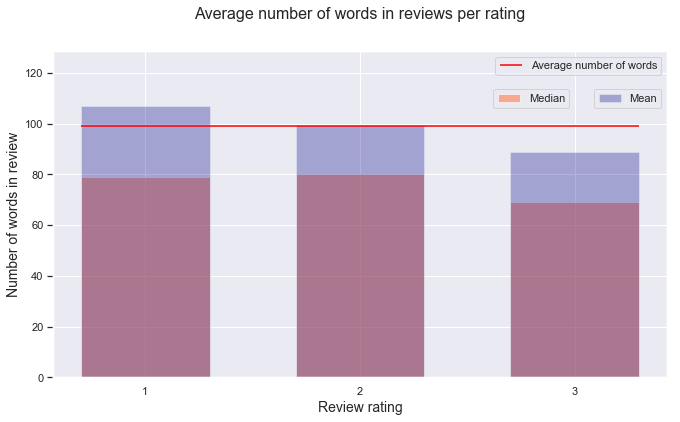

In [60]:
mean = corpus_processed[['rating', 'words']].groupby('rating')['words'].mean()
median = corpus_processed[['rating', 'words']].groupby('rating')['words'].median()
mean_data = corpus_processed.words.mean()

score = np.arange(1,4)
fig, ax = plt.subplots(figsize=(11,6))
ax2 = ax.twinx() #set ax2 on same x axis as ax
ax3 = ax.twinx() #same as above, for hline
width = 0.6
ax.bar(x=score, height=median, width=width, label="Median", color="coral", alpha=0.6)
ax2.bar(x=score, height=mean, width=width, label="Mean", color="darkblue", alpha=0.3)
ax3.hlines(mean_data, .7 ,3.3, colors="red", label="Average number of words")


ax.set_ylim(0,1.2*mean.max())
ax2.set_ylim(0,1.2*mean.max())
ax3.set_ylim(0,1.2*mean.max())

ax2.yaxis.set_visible(False) #hide the 2nd axis
ax3.yaxis.set_visible(False)
ax.set_xticks([1,2,3])

ax.legend(bbox_to_anchor=(-0.15, 0,1, 0.9), loc="upper right")
ax2.legend(bbox_to_anchor=(0,-.1,1,1), loc="upper right")
# ax3.legend(bbox_to_anchor=(0,0,1,1), loc="upper left")

ax.set_ylabel("Number of words in review", size=14)
ax.set_xlabel("Review rating", size=14)
plt.title("Average number of words in reviews per rating", size=16, y=1.08)
plt.legend()

plt.savefig(fname='../images/words_distribution', bbox_inches='tight', pad_inches=.1)
plt.show();

### Looks like reviews with higher ratings on average tend to have less words

In [10]:
# Tokenizing all reviews and locating in 1 list all words

processed_corpus = list(map(tokenize_text, corpus_processed['clean_text']))

### Lets Plot frequency distribution of tokens in whole corpus

In [11]:
def plot_frequency(data):
    """
    Ploting words frequency distribution
    from corpus. data should be list of lists with strings
    """
    words_lst = []
    for review in data:
        for token in review:
            words_lst.append(token)

    fdist = FreqDist(words_lst)
    plt.figure(figsize=(10,6))
    fdist.plot(30, title = "Frequency distribution of words within corpus")
    plt.show()

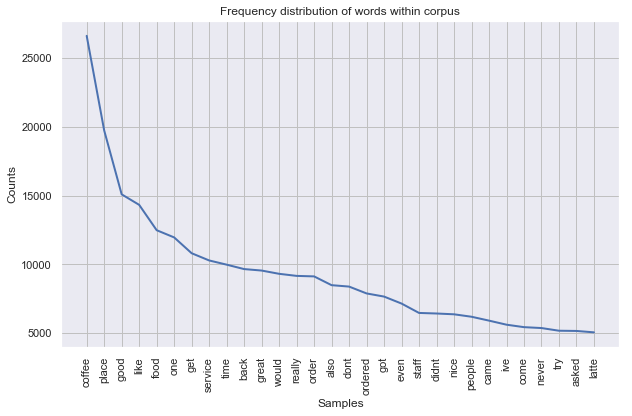

In [12]:
plot_frequency(processed_corpus)

## Lets Find Out Most Common Words in each Class

In [13]:
corpus_1 = corpus_processed[corpus_processed['rating']=='Negative']
corpus_2 = corpus_processed[corpus_processed['rating']=='Neutral']
corpus_3 = corpus_processed[corpus_processed['rating']=='Positive']
#corpus_4 = corpus_processed[corpus_processed['rating']=='4 star rating']
#corpus_5 = corpus_processed[corpus_processed['rating']=='5 star rating']

In [14]:
corpus_by_class = [corpus_1, corpus_2, corpus_3]

In [15]:
data_class = [corpus['clean_text'] for corpus in corpus_by_class]

In [16]:
def freq_wrds_class(data, n = 20, top= True):
    
    """
    Returns list of 2 tuples that represents frequency
    of words in document
    
    data - Series with string data
    n - number of most common words to show
    """
    
    protc_data = list(map(tokenize_text, data))
    
    total_vocab = set()
    for comment in protc_data:
        total_vocab.update(comment)
    
    if top:
        i = 1
        print('Total words in vocab : {}'.format(len(total_vocab)))
        #print (30*'-')
        #print('Top {} most frequent words:'.format(n))
        flat_data = [item for sublist in protc_data for item in sublist]
        freq = FreqDist(flat_data)
        
        return freq.most_common(n)
    
    flat_data = [item for sublist in protc_data for item in sublist]
    freq = FreqDist(flat_data)
    return freq.most_common(len(total_vocab))

In [17]:
def visual_freq(data):
    """
    data - list of pandas.core.series.Series
           with text in each row 
    """
    
    class_freq = [freq_wrds_class(data_class) for data_class in data]
    bar_count_bar_wrds = [([x[1] for x in clas], [x[0] for x in clas]) for clas in class_freq]
    
    # set the color of our bar graphs
    color = cm.viridis_r(np.linspace(.8,.16, 30))
    
    fig, ax = plt.subplots(len(bar_count_bar_wrds), 1, figsize=(3*len(bar_count_bar_wrds), 4*len(bar_count_bar_wrds)))
    ratings = ['Negative', 'Neutral', 'Positive']
    i = 0
    for b_c_b_v in bar_count_bar_wrds:
        bar_count, bar_wrds = b_c_b_v
        ax[i].bar(bar_wrds, bar_count, color=color)
        ax[i].title.set_text('{} star rating'.format(ratings[i]))
        i+=1
    
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=60)

    plt.tight_layout(pad=0)
    
    plt.show()

Total words in vocab : 38450
Total words in vocab : 17025
Total words in vocab : 32720


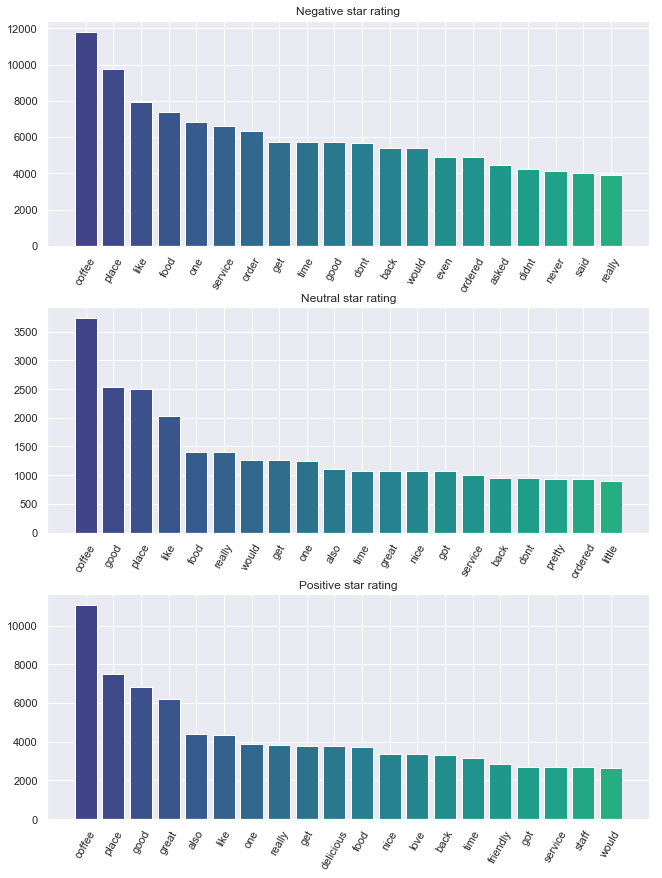

In [124]:
visual_freq(data_class)

### As we can see Lots of same words showing up in all classes

# Creating Bigrams

Knowing individual word frequencies is somewhat informative, but in practice, some of these tokens are actually parts of larger phrases that should be treated as a single unit. Let's create some bigrams, and see which combinations of words are most telling.

In [18]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [19]:
tokens_by_class = []
for w_class in data_class:
    tokens_by_class.append([item for sublist in list(map(tokenize_text, w_class)) for item in sublist])

In [127]:
len(tokens_by_class)

3

In [30]:
bigram_finder = BigramCollocationFinder.from_words(tokens_by_class[0])

In [31]:
corpus_scored = bigram_finder.score_ngrams(bigram_measures.raw_freq)

In [32]:
corpus_scored[:20]

[(('customer', 'service'), 0.0018277307253048189),
 (('coffee', 'shop'), 0.0010002148457376764),
 (('behind', 'counter'), 0.0008552710705588354),
 (('first', 'time'), 0.0007175230856370998),
 (('tasted', 'like'), 0.0007175230856370998),
 (('dont', 'know'), 0.0007031315051228887),
 (('come', 'back'), 0.0006034184115601398),
 (('iced', 'coffee'), 0.0005468800595400245),
 (('coming', 'back'), 0.0005407122393196484),
 (('even', 'though'), 0.0005294045689156253),
 (('didnt', 'even'), 0.0005232367486952491),
 (('going', 'back'), 0.0004677263667118631),
 (('cream', 'cheese'), 0.0004636144865649456),
 (('ice', 'cream'), 0.0004471669659772757),
 (('cup', 'coffee'), 0.00042146771505904146),
 (('ive', 'ever'), 0.00041118801469174776),
 (('every', 'time'), 0.00037212515329603174),
 (('cold', 'brew'), 0.0003649293630389261),
 (('like', 'place'), 0.00034128605219415064),
 (('dont', 'think'), 0.0003361462020105038)]

# Visualizing Bigram Frequency

In [33]:
def visulize_w_grams(data_token_class, n=2):
    ratings = ['Negative', 'Neutral', 'Positive']
    for i,tokens_by_class in enumerate(data_token_class):
        bigrams_series = (pd.Series(nltk.ngrams(tokens_by_class, n)).value_counts())[:20]
        bigrams_series.sort_values().plot.barh(color=cm.viridis_r(np.linspace(.4,.8, 30)), width=.9, figsize=(10, 4))
        plt.title('20 Most Frequently Occurring in {}-grams of class {}-review'.format(n,ratings[i]), fontsize=18)
        plt.ylabel('{}-gram'.format(n), fontsize=18)
        plt.xlabel('Number of Occurances', fontsize=18)
        plt.show()

In [34]:
three_1 = (pd.Series(nltk.ngrams(tokens_by_class[0], 3))).values
three_2 = (pd.Series(nltk.ngrams(tokens_by_class[1], 3))).values
three_3 = (pd.Series(nltk.ngrams(tokens_by_class[2], 3))).values
#three_4 = (pd.Series(nltk.ngrams(tokens_by_class[3], 3))).values
#three_5 = (pd.Series(nltk.ngrams(tokens_by_class[4], 3))).values

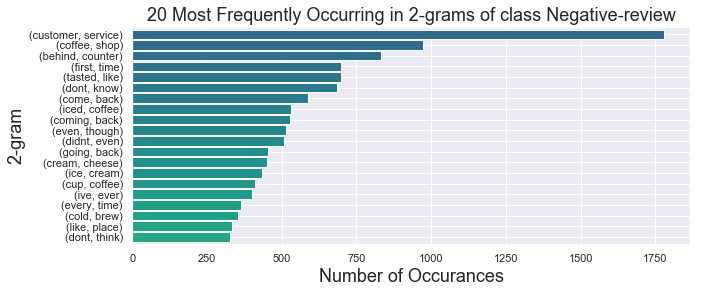

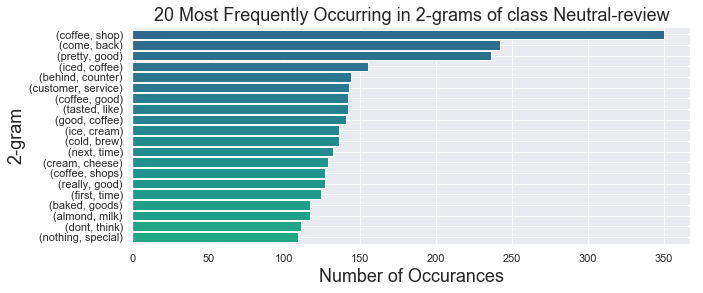

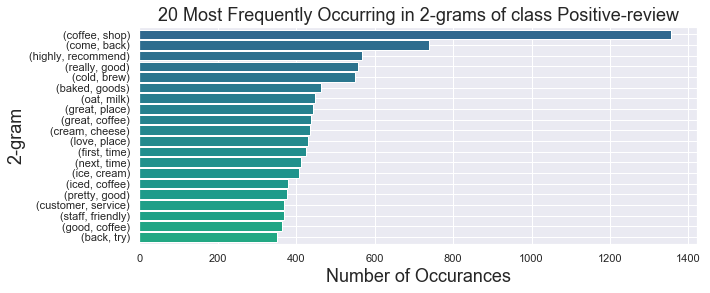

In [35]:
visulize_w_grams(tokens_by_class)

# Creating 3 - grams

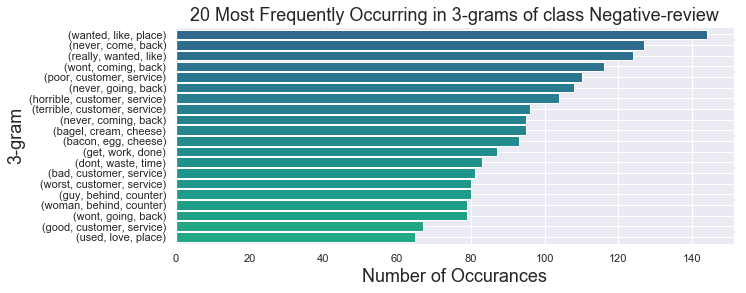

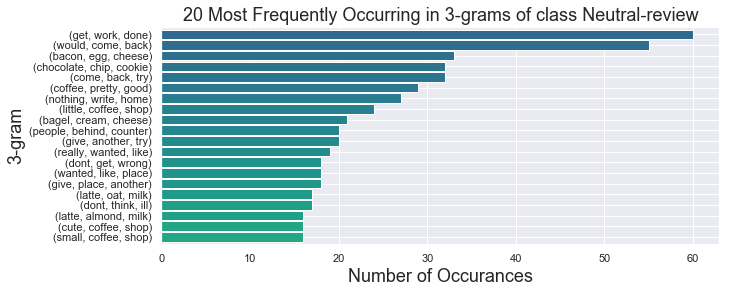

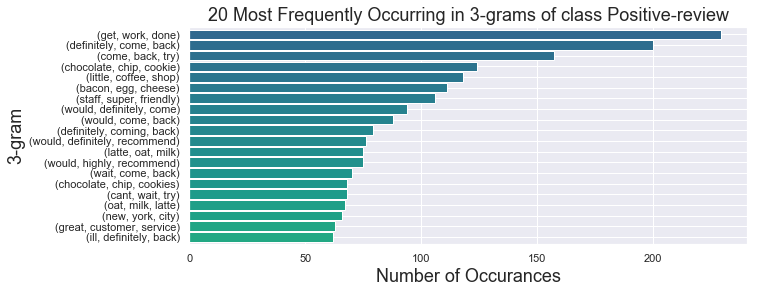

In [36]:
visulize_w_grams(tokens_by_class, n=3)

## Checking unique 3-grams words in all all Classes 

In [37]:
class_wocab = [freq_wrds_class(data, top = False) for data in data_class]

In [38]:
words_by_class = []
for data_class in class_wocab:
    words_by_class.append([t[0] for t in data_class])

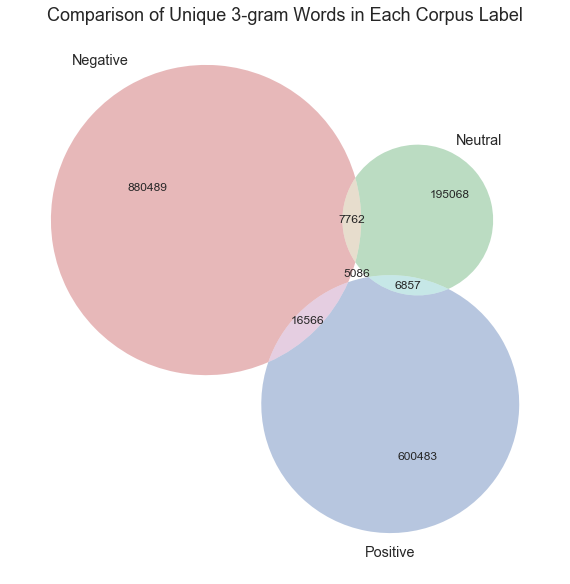

In [46]:
plt.figure(figsize=(10,10), facecolor='w')
venn3([set(three_1), set(three_2), set(three_3)], set_labels = ('Negative', 'Neutral', 'Positive'))
plt.title('Comparison of Unique 3-gram Words in Each Corpus Label', size=18)
plt.savefig('../images/venn-3.png')
plt.show()

## Checking 3-grams words in Negative and Neutral class

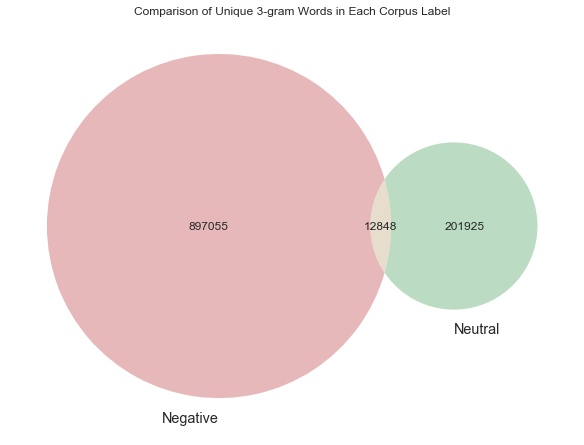

In [40]:
plt.figure(figsize=(10,10), facecolor='w')
venn2([set(three_1), set(three_2),], set_labels = ('Negative', 'Neutral'))
plt.title('Comparison of Unique 3-gram Words in Each Corpus Label')
# plt.savefig('../images/venn.png')
plt.show()

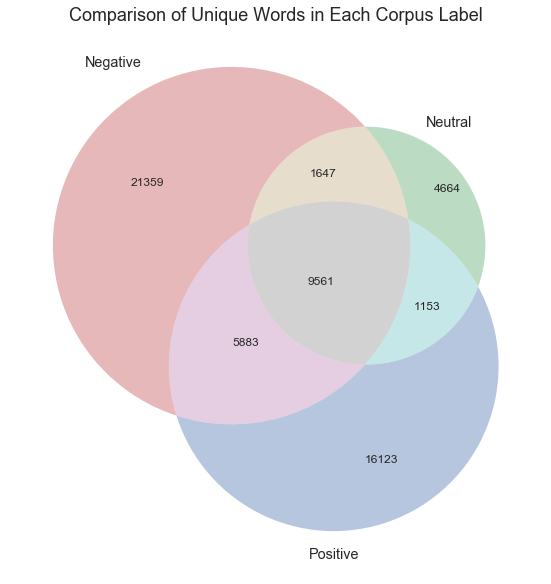

In [45]:
plt.figure(figsize=(10,10), facecolor='w')
venn3([set(words_by_class[0]), set(words_by_class[1]), set(words_by_class[2])], set_labels = ('Negative', 'Neutral', 'Positive'))
plt.title('Comparison of Unique Words in Each Corpus Label', size=18)
plt.savefig('../images/venn-uni.png')
plt.show()

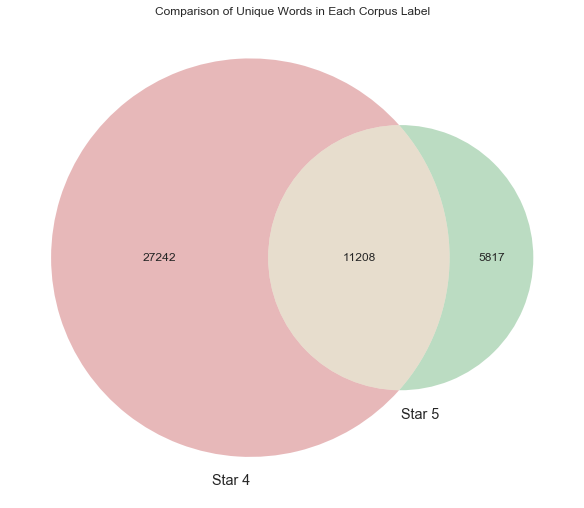

In [42]:
plt.figure(figsize=(10,10), facecolor='w')
venn2([set(words_by_class[0]), set(words_by_class[1])], set_labels = ('Star 4', 'Star 5'))
plt.title('Comparison of Unique Words in Each Corpus Label')
# plt.savefig('../images/venn.png')
plt.show()

In [382]:
cursor.close()
conn.close()